# Dyad Position Predictor - Apply Pretrained Model
Apply a pretrained neural network to predict dyad positions on chromatin fiber sequences.

## 1. Imports and setup
Load core libraries (NumPy, PyTorch, Matplotlib), utilities, and project helpers.

In [1]:
import numpy as np
import sys
from pathlib import Path

# Add parent directory to path so nuctool package can be imported
parent_path = Path.cwd().parent
if str(parent_path) not in sys.path:
    sys.path.insert(0, str(parent_path))

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from icecream import ic

from nuctool.ChromatinFibers import read_simulation_results
from nuctool.Plotter import Plotter

plot = Plotter()
FILEOUT = rf"figures/Apply_DyadPredictor.jpg"
FILEOUT = None

## 2. Configuration
Specify the data file and pretrained model to use.

In [2]:
# Path to HDF5 data file with chromatin fiber sequences
data_filename = rf"../data/LLM models/test_5000.h5"

# Path to pretrained model
model_filename = rf"../data/LLM models/test_5000.pt"
model_filename = rf"../data/LLM models/test_15000_dilated.pt"

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 3. Define model architecture
Define the DyadPredictor model architecture (must match the pretrained model).

In [3]:
class DyadPredictor(nn.Module):
    """Per-position dyad predictor using Conv1d and bidirectional context."""

    def __init__(
        self, 
        vocab_size=8, 
        embedding_dim=16, 
        hidden_dim=64, 
        num_layers=2, 
        dropout=0.3,
        conv_layers=2,
        conv_kernel_size=5,
        conv_dilations=None
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.conv_layers = conv_layers

        # Embedding layer (map 0-7 to dense vectors)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Conv blocks for local context (with optional dilation)
        if conv_dilations is None:
            conv_dilations = [1] * conv_layers
        
        # Create convolutional layers with legacy naming for compatibility
        for i in range(conv_layers):
            in_channels = embedding_dim if i == 0 else hidden_dim
            dilation = conv_dilations[i] if i < len(conv_dilations) else 1
            padding = (conv_kernel_size - 1) * dilation // 2
            
            conv = nn.Conv1d(
                in_channels, 
                hidden_dim, 
                kernel_size=conv_kernel_size, 
                padding=padding,
                dilation=dilation
            )
            bn = nn.BatchNorm1d(hidden_dim)
            
            # Register with names that match saved state dict
            setattr(self, f'conv{i+1}', conv)
            setattr(self, f'bn{i+1}', bn)

        # BiLSTM for global context
        self.lstm = nn.LSTM(
            hidden_dim,
            hidden_dim // 2,
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
        )

        # Output head
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1),
        )

    def forward(self, x):
        """Forward pass.
        Args:
            x: (batch_size, seq_len) - encoded sequence
        Returns:
            logits: (batch_size, seq_len, 1) - per-position dyad logits
        """
        # Embedding: (batch, seq_len) -> (batch, seq_len, embed_dim)
        x = self.embedding(x)

        # Conv blocks: (batch, seq_len, embed_dim) -> (batch, embed_dim, seq_len)
        x = x.transpose(1, 2)
        
        for i in range(self.conv_layers):
            conv = getattr(self, f'conv{i+1}')
            bn = getattr(self, f'bn{i+1}')
            x = conv(x)
            x = bn(x)
            x = torch.relu(x)

        # Back to (batch, seq_len, hidden_dim)
        x = x.transpose(1, 2)

        # LSTM: (batch, seq_len, hidden_dim) -> (batch, seq_len, hidden_dim)
        x, _ = self.lstm(x)

        # Per-position classification: (batch, seq_len, hidden_dim) -> (batch, seq_len, 1)
        logits = self.fc(x)

        return logits

## 4. Define prediction function
Function to predict dyad positions from an encoded DNA sequence.

In [4]:
def predict_dyads(model, encoded_sequence, threshold=0.2, device="cpu"):
    """
    Predict dyad positions for a single sequence.

    Args:
        model: trained DyadPredictor
        encoded_sequence: list/array of integers (0-7)
        threshold: probability threshold for positive class (default 0.2)
        device: torch device

    Returns:
        dyad_positions: list of predicted dyad positions
        probabilities: array of per-position probabilities
    """
    model.eval()
    with torch.no_grad():
        seq_tensor = torch.LongTensor(encoded_sequence).unsqueeze(0).to(device)
        logits = model(seq_tensor)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()

    dyad_positions = np.where(probs >= threshold)[0].tolist()
    return dyad_positions, probs

## 5. Load pretrained model
Load the model weights from the saved checkpoint file.

In [5]:
# Load config to get model hyperparameters
config_path = Path(model_filename).with_suffix(".json")

with open(config_path, "r") as f:
    config = json.load(f)

llm_cfg = config.get("llm", {})

# Extract model parameters from config
model_params = {
    "vocab_size": llm_cfg.get("vocab_size", 8),
    "embedding_dim": llm_cfg.get("embedding_dim", 16),
    "hidden_dim": llm_cfg.get("hidden_dim", 64),
    "num_layers": llm_cfg.get("num_layers", 2),
    "dropout": llm_cfg.get("dropout", 0.3),
    "conv_layers": llm_cfg.get("conv_layers", 2),
    "conv_kernel_size": llm_cfg.get("conv_kernel_size", 5),
    "conv_dilations": llm_cfg.get("conv_dilations", None),
}

print(f"Model configuration from {config_path.name}:")
print(f"  Architecture: {llm_cfg.get('model_type', 'standard')}")
print(f"  Embedding dim: {model_params['embedding_dim']}")
print(f"  Hidden dim: {model_params['hidden_dim']}")
print(f"  Conv layers: {model_params['conv_layers']}")
print(f"  Conv kernel size: {model_params['conv_kernel_size']}")
print(f"  Conv dilations: {model_params['conv_dilations']}")
print(f"  LSTM layers: {model_params['num_layers']}")
print(f"  Dropout: {model_params['dropout']}")

loaded_model = DyadPredictor(**model_params)
loaded_model.load_state_dict(torch.load(model_filename, map_location=device))
loaded_model = loaded_model.to(device)
loaded_model.eval()

print(f"\nLoaded pretrained model from: {model_filename}")
print(f"Model parameters: {sum(p.numel() for p in loaded_model.parameters()):,}")

Model configuration from test_15000_dilated.json:
  Architecture: dilated_convolutions
  Embedding dim: 32
  Hidden dim: 128
  Conv layers: 4
  Conv kernel size: 7
  Conv dilations: [1, 2, 4, 8]
  LSTM layers: 3
  Dropout: 0.3

Loaded pretrained model from: ../data/LLM models/test_15000_dilated.pt
Model parameters: 680,833


## 6. Apply model to a single sample
Load a random sample from the data file and visualize predictions.

Loaded sample 538 from ../data/LLM models/test_5000.h5
Sequence length: 10000 bp
Number of true dyads: 45
Number of predicted dyads: 519


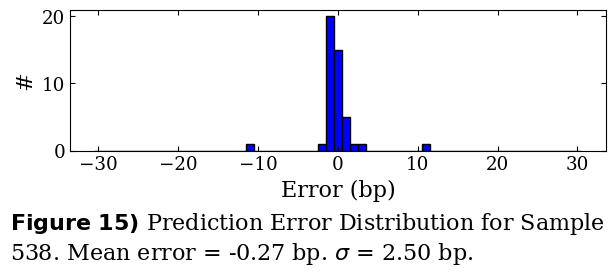

In [24]:
# Get a random sample from the HDF5 file
data_params = read_simulation_results(data_filename)
idx = np.random.randint(0, data_params.n_samples)
dyad_positions_sample, encoded_seq_sample, methylated_seq = read_simulation_results(
    data_filename, idx
)

print(f"Loaded sample {idx} from {data_filename}")
print(f"Sequence length: {len(encoded_seq_sample)} bp")
print(f"Number of true dyads: {len(dyad_positions_sample)}")

# Predict dyads
dyads, probs = predict_dyads(loaded_model, encoded_seq_sample, device=device)

print(f"Number of predicted dyads: {len(dyads)}")

# Compute prediction errors for true dyad positions
error = [np.argmax(probs[i - 65 : i + 65]) - 65 for i in dyad_positions_sample]

# Plot error distribution for this sample
plot.new(fig_size=(6, 2))
plt.hist(np.array(error), range=(-30.5, 30.5), bins=61, color="blue", edgecolor="black")
plt.xlabel("Error (bp)")
plt.ylabel("#")

plot.caption(
    f"Prediction Error Distribution for Sample {idx}. Mean error = {np.mean(error):.2f} bp. $\\sigma$ = {np.std(error):.2f} bp.", filename=FILEOUT
)
plt.show()

## 7. Visualize predictions
Create detailed plots showing predicted vs. true dyad positions along the sequence.

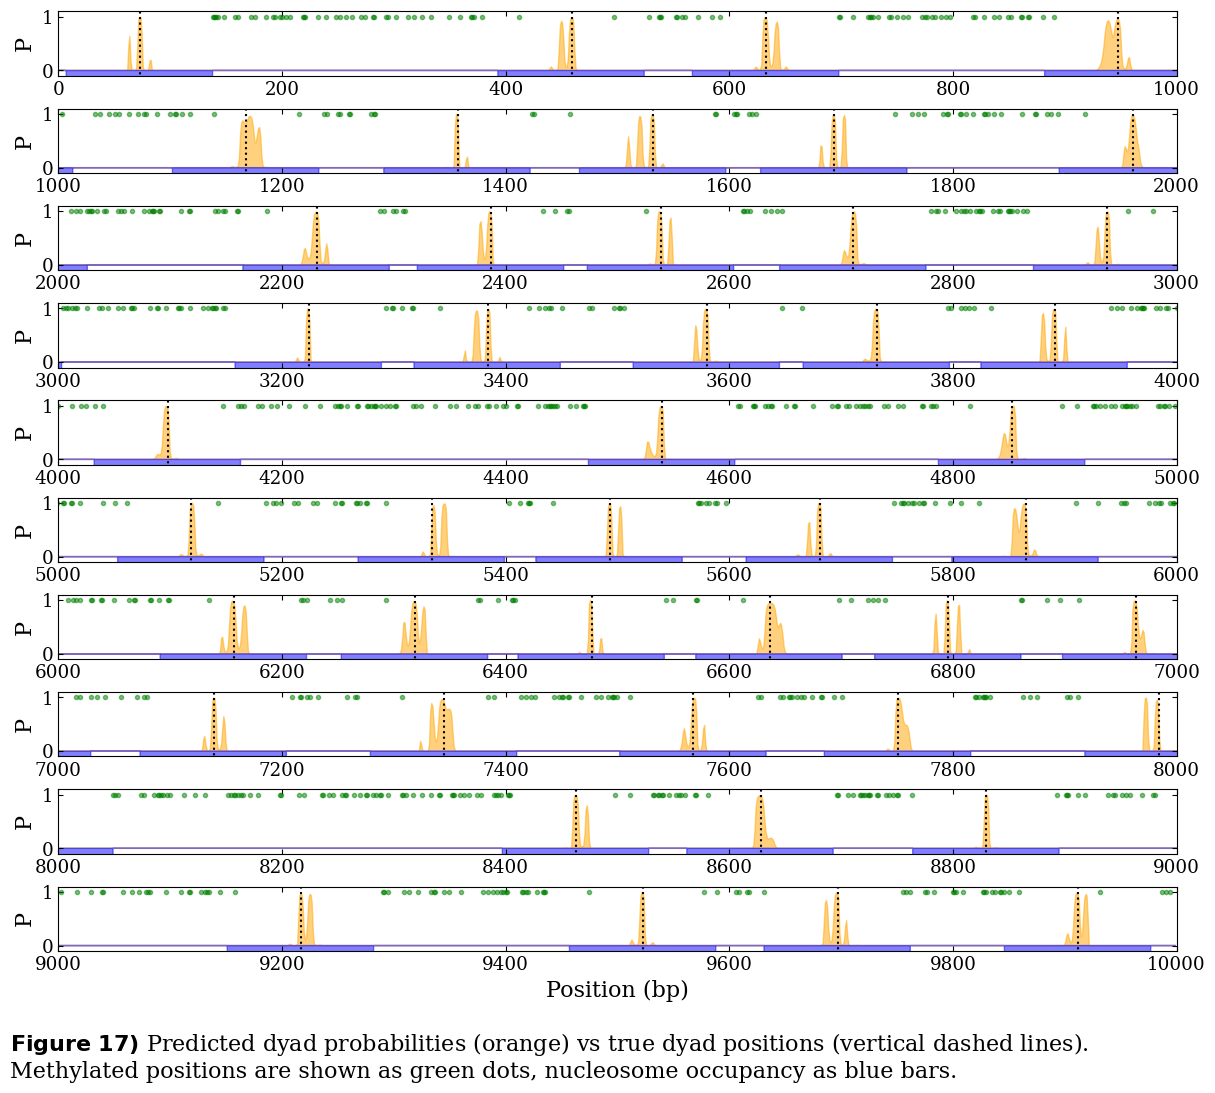

In [26]:
index = np.arange(len(encoded_seq_sample))
nucs = np.zeros_like(index)
nucs[dyad_positions_sample] = 1.0

for i in dyad_positions_sample:
    nucs[i - 65 : i + 65] = -1  # highlight nucleosome region


n_plots = 10
plot.new(fig_size=(12, n_plots), nrows=n_plots, sharex=False)
for i, panel in enumerate(plot.panels):

    panel.vlines(
        dyad_positions_sample,
        ymin=-1,
        ymax=2,
        color="black",
        linestyles="dotted",
        alpha=1,
    )
    panel.fill_between(
        index, probs, label="Predicted Dyad Probability", color="orange", alpha=0.5
    )
    panel.fill_between(
        index, nucs, color="blue", alpha=0.5, label="True Dyad Positions"
    )

    methylations = np.zeros_like(index) * np.nan
    methylations[index[encoded_seq_sample > 4]] = 1
    panel.plot(
        index,
        methylations,
        "o",
        label="Methylations",
        color="green",
        alpha=0.5,
        fillstyle="full",
        markersize=3,
    )

    panel.set_xlim(i * len(index) // n_plots, (i + 1) * len(index) // n_plots)
    panel.set_ylabel("P")
    panel.set_ylim(-0.1, 1.1)

plot.panels[-1].set_xlabel("Position (bp)")
caption = "Predicted dyad probabilities (orange) vs true dyad positions (vertical dashed lines). "
caption += "Methylated positions are shown as green dots, nucleosome occupancy as blue bars."
plot.caption(caption, filename=FILEOUT)
# plt.show()

## 8. Batch evaluation on multiple samples
Evaluate the model on multiple samples and compute aggregate statistics.

In [29]:
# Evaluate on multiple random samples
bins = np.linspace(-30.5, 30.5, 62)
all_errors = []
n_samples = 500

for idx in tqdm(
    np.random.choice(data_params.n_samples, size=n_samples, replace=False),
    desc="Computing prediction errors",
):
    dyad_positions_sample, encoded_seq_sample, methylated_seq = read_simulation_results(
        data_filename, int(idx)
    )
    dyads, probs = predict_dyads(loaded_model, encoded_seq_sample, device=device)

    # For each true dyad, find the closest predicted dyad and compute error
    seq_len = len(probs)
    for true_dyad in dyad_positions_sample:
        error = np.argmax(probs[true_dyad - 65 : true_dyad + 65]) - 65
        all_errors.append(error)

Computing prediction errors: 100%|██████████| 500/500 [00:23<00:00, 20.89it/s]


## 9. Fit error distribution
Fit the error distribution to a three-Gaussian model to characterize prediction accuracy.

0.8644120384734719


TypeError: only integer scalar arrays can be converted to a scalar index

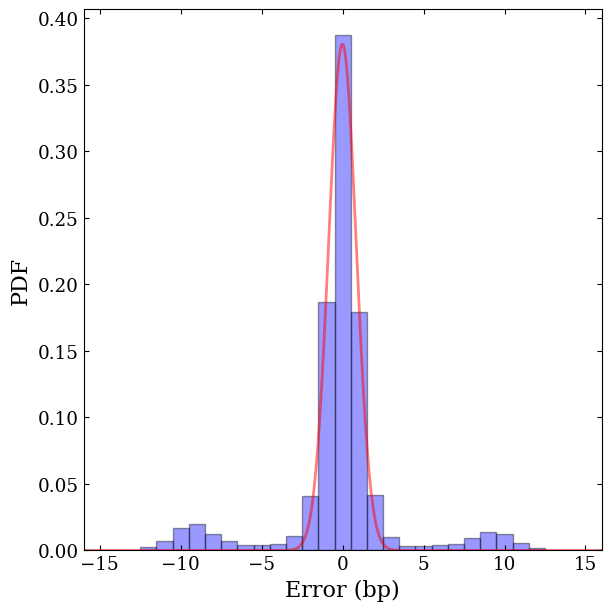

In [ ]:
from scipy.optimize import curve_fit


def three_gaussians(x, fraction, std, shift, std2):
    """Model function: sum of three Gaussian distributions."""
    mean = 0
    # std2 = std
    gauss1 = (fraction / std) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    gauss2 = (0.5 * (1 - fraction) / std) * np.exp(
        -0.5 * ((x - mean - shift) / std2) ** 2
    )
    gauss3 = (0.5 * (1 - fraction) / std) * np.exp(
        -0.5 * ((x - mean + shift) / std2) ** 2
    )
    result = gauss1 + gauss2 + gauss3
    result = result / np.sum(result)  # Normalize area to 1
    result = result / np.median(np.diff(x))
    return result

def gaussian(x, amplitude, mean, stddev):
    """Single Gaussian function."""
    return amplitude * np.exp(-0.5 * ((x - mean) / stddev) ** 2)

# Create normalized histogram
histogram, x_hist = np.histogram(all_errors, bins=bins)
histogram = histogram / np.sum(histogram)  # Normalize to area=1
xhist = (x_hist[:-1] + x_hist[1:]) / 2  # bin centers

# # Fit model with bounds on std2
# fit_params_init = {"fraction": 0.9, "std": 4.0, "shift": 9.5, "std2": 1.0}
# popt, pcov = curve_fit(
#     three_gaussians,
#     xhist,
#     histogram,
#     p0=[
#         fit_params_init["fraction"],
#         fit_params_init["std"],
#         fit_params_init["shift"],
#         fit_params_init["std2"],
#     ],
#     bounds=([0, 0, 0, 0], [1, np.inf, np.inf, 1])
# )

# fit gausian
fit_params_init = {"amplitude": 0.1, "mean": 0.0, "stddev": 4.0}
popt, pcov = curve_fit(
    gaussian,
    xhist[np.abs(xhist) < 5],
    histogram[np.abs(xhist) < 5],
    p0=[
        fit_params_init["amplitude"],
        fit_params_init["mean"],
        fit_params_init["stddev"],
    ],
    bounds=([0, -5, 0], [1, 5, np.inf])
)   

# Plot results
plot.new(fig_size=(6, 6), fig_num=4)
plt.bar(
    xhist,
    histogram,
    width=np.diff(xhist)[0],
    align="center",
    alpha=0.4,
    color="blue",
    edgecolor="black",
)
plt.xlabel("Error (bp)")
plt.ylabel("PDF")

three_gaussians_x = np.linspace(-30, 30, 1000)
legend_text = f"Main peak: {popt[0]:.0%}\nStd dev.: {popt[1]:.2f} bp"
plt.plot(
    three_gaussians_x,
    gaussian(three_gaussians_x, *popt),
    color="red",
    linewidth=2,
    label=legend_text,
    alpha=0.5,
)

plt.xlim(-16, 16)
# plt.yscale("log")
# plt.ylim(1e-4, None)

all_errors_arr = np.array(all_errors)
print(np.sum(histogram[np.abs(xhist) < 5]))
print(np.std(all_errors_arr[np.abs(all_errors_arr) < 5.0]))

caption = "Most dyads are found within 1 bp accuracy. "
caption += f"Error distribution fit to a triple Gaussian. Main peak = {popt[0]:.0%}, $\\sigma$ = {popt[1]:.2f} bp."

ic(popt)

plot.caption(caption, filename=FILEOUT
)
# plotter.save_figure("error_distribution")
plt.show()

## 10. Apply to custom sequence (optional)
You can also apply the model to your own encoded sequence.

In [10]:
# Example: Create or load your own encoded sequence
# custom_sequence = np.array([0, 1, 2, 3, 4, 5, 6, 7, ...])  # Your encoded DNA sequence (values 0-7)

# Uncomment to use:
# dyads_custom, probs_custom = predict_dyads(loaded_model, custom_sequence, device=device)
# print(f"Predicted {len(dyads_custom)} dyads in custom sequence")

print("To apply the model to your own sequence:")
print(
    "1. Encode your DNA sequence (0-7 encoding: A=0, C=1, G=2, T=3, mA=4, mC=5, mG=6, mT=7)"
)
print(
    "2. Call: dyads, probs = predict_dyads(loaded_model, your_encoded_sequence, device=device)"
)
print(
    "3. Use probs array for per-position probabilities or dyads list for high-confidence positions"
)

To apply the model to your own sequence:
1. Encode your DNA sequence (0-7 encoding: A=0, C=1, G=2, T=3, mA=4, mC=5, mG=6, mT=7)
2. Call: dyads, probs = predict_dyads(loaded_model, your_encoded_sequence, device=device)
3. Use probs array for per-position probabilities or dyads list for high-confidence positions
